In [68]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [181]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [182]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [183]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2018-10-01' (64,908,446) TAKES ~15 MINS
#PULLING IN ALL REVIEWS SINCE '2020-01-01' (30,174,364) TAKES ~15 MINS (Not any shorter?)
#PULLING IN ALL REVIEWS SINCE '2018-10-01' with NR label only (510,253) TAKES ~few MINS 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   135665649 2017-12-22 17:01:41   
1   136059039 2017-12-29 05:23:20   
2   136087337 2017-12-29 15:33:54   
3   136061518 2017-12-29 06:34:32   
4   135666042 2017-12-22 17:05:51   
..        ...                 ...   
95  253207877 2019-09-17 11:32:33   
96  253208366 2019-09-17 11:44:21   
97  253207441 2019-09-17 11:24:07   
98  253208213 2019-09-17 11:42:00   
99  253207935 2019-09-17 11:35:05   

                                    REVIEW_HEADLINE  \
0   No!                                               
1   Would buy                                         
2   No                                                
3   Worst Customer Service Ever!!!                    
4   Not sure if the delivery service is trustworthy   
..                                              ...   
95  Don't us online                                   
96  Too much packaging                                
97  NEVER RECEIVED                                    
98  E

In [184]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512212 entries, 0 to 512211
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             512212 non-null  int64         
 1   CREATED_DATE       512212 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    511745 non-null  object        
 3   REVIEW_COMMENTS    511255 non-null  object        
 4   REVIEW_RATING      511972 non-null  float64       
 5   REVIEWER_NICKNAME  511967 non-null  object        
 6   REVIEWER_LOCATION  511972 non-null  object        
 7   OBSERVATIONS       512212 non-null  object        
 8   PM                 512212 non-null  int64         
 9   NR                 512212 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 39.1+ MB

In [185]:
query_testing_2 = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [186]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64677672 entries, 0 to 64677671
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   UGC_ID             int64  
 1   CREATED_DATE       object 
 2   REVIEW_HEADLINE    object 
 3   REVIEW_COMMENTS    object 
 4   REVIEW_RATING      float64
 5   REVIEWER_NICKNAME  object 
 6   REVIEWER_LOCATION  object 
 7   OBSERVATIONS       object 
 8   PM                 int64  
 9   NR                 int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 4.8+ GB

In [187]:
#Using limit 500000 is not random, pull in all w/ no labels and then take random sample from there
from random import sample 
reviews_2 = reviews_2.sample(n=512212, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [188]:
reviews_2['NR'].sum(axis=0)
#reviews_2[reviews_2['NR']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [189]:
reviews = pd.concat([reviews, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             UGC_ID         CREATED_DATE  \
0         135665649  2017-12-22 17:01:41   
1         136059039  2017-12-29 05:23:20   
2         136087337  2017-12-29 15:33:54   
3         136061518  2017-12-29 06:34:32   
4         135666042  2017-12-22 17:05:51   
...             ...                  ...   
10617122  301411597  2018-08-16 20:27:00   
58619115  297344899  2019-12-26 23:00:00   
34909466  297712770  2014-08-05 00:00:00   
34628021  258688737  2016-02-29 16:00:00   
1186282   266361662  2017-03-02 16:00:00   

                                          REVIEW_HEADLINE  \
0         No!                                               
1         Would buy                                         
2         No                                                
3         Worst Customer Service Ever!!!                    
4         Not sure if the delivery service is trustworthy   
...                                                   ...   
10617122  Nexcare Waterproof Bandages       

In [190]:
reviews['NR'].sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

512212

In [191]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024424 entries, 0 to 1186282
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   UGC_ID             1024424 non-null  int64  
 1   CREATED_DATE       1024424 non-null  object 
 2   REVIEW_HEADLINE    1023947 non-null  object 
 3   REVIEW_COMMENTS    1023463 non-null  object 
 4   REVIEW_RATING      1024184 non-null  float64
 5   REVIEWER_NICKNAME  1024178 non-null  object 
 6   REVIEWER_LOCATION  1024183 non-null  object 
 7   OBSERVATIONS       1024424 non-null  object 
 8   PM                 1024424 non-null  int64  
 9   NR                 1024424 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 86.0+ MB

In [192]:
#reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [193]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [194]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [195]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [196]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [197]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID         CREATED_DATE  \
0   135665649  2017-12-22 17:01:41   
1   136059039  2017-12-29 05:23:20   
2   136087337  2017-12-29 15:33:54   
3   136061518  2017-12-29 06:34:32   
4   135666042  2017-12-22 17:05:51   
..        ...                  ...   
95  253207877  2019-09-17 11:32:33   
96  253208366  2019-09-17 11:44:21   
97  253207441  2019-09-17 11:24:07   
98  253208213  2019-09-17 11:42:00   
99  253207935  2019-09-17 11:35:05   

                                    REVIEW_HEADLINE  \
0   No!                                               
1   Would buy                                         
2   No                                                
3   Worst Customer Service Ever!!!                    
4   Not sure if the delivery service is trustworthy   
..                                              ...   
95  Don't us online                                   
96  Too much packaging                                
97  NEVER RECEIVED                              

In [198]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024424 entries, 0 to 1186282
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   UGC_ID             1024424 non-null  int64  
 1   CREATED_DATE       1024424 non-null  object 
 2   REVIEW_HEADLINE    1023947 non-null  object 
 3   REVIEW_COMMENTS    1023463 non-null  object 
 4   REVIEW_RATING      1024184 non-null  float64
 5   REVIEWER_NICKNAME  1024178 non-null  object 
 6   REVIEWER_LOCATION  1024183 non-null  object 
 7   OBSERVATIONS       1024424 non-null  object 
 8   PM                 1024424 non-null  int64  
 9   NR                 1024424 non-null  int64  
 10  ALL_TEXT           1023227 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 93.8+ MB

In [199]:
X = reviews[['ALL_TEXT','REVIEW_RATING']]
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ALL_TEXT  \
0         headline No! comment Never received.                                                                                                                                                                                                                                                                                                                                                                                                                                     
1         headline Would buy comment clouds                     

In [200]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          NR
0         1 
1         1 
2         1 
3         1 
4         1 
...      .. 
10617122  0 
58619115  0 
34909466  0 
34628021  0 
1186282   0 

[1024424 rows x 1 columns]

In [201]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    512212
dtype: int64

In [202]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [203]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [204]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))
#25 mins for 65 mil rows
#16 mins for 30 mil rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [205]:
print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  (0, 18319)	0.28701556733239725
  (0, 3433)	0.2754176598399008
  (0, 15779)	0.2784804819151863
  (0, 20465)	0.18887688798291732
  (0, 6070)	0.0623305926522778
  (0, 8252)	0.5413752823131864
  (0, 29400)	0.6539754714627288
  (0, 12715)	0.0623305926522778
  (1, 11065)	0.32510751563521156
  (1, 26830)	0.15409704184641038
  (1, 15756)	0.45229498789398753
  (1, 11695)	0.21636899680404956
  (1, 7687)	0.34834899807480324
  (1, 23671)	0.19112341508422925
  (1, 18447)	0.3074588261200079
  (1, 27049)	0.29352630470714264
  (1, 5034)	0.2823003086521762
  (1, 22174)	0.17505869971388313
  (1, 28756)	0.40820921090800083
  (1, 6070)	0.042634071302244635
  (1, 12715)	0.042634071302244635
  (2, 8093)	0.40319830443812027
  (2, 17737)	0.37614212841060446
  (2, 28963)	0.8228996266307845
  (2, 6070)	0.09691344340152315
  :	:
  (819535, 20465)	0.16470319020426644
  (819535, 6070)	0.05435311629065626
  (819535, 12715)	0.05435311629065626
  (819536, 6074)	0.7876492764836794
  (819536, 22174)	0.582540026663911

In [206]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [207]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
#ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(808202,1)
#print(ratings_vector_xtrain)
#ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(202051,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [208]:
#Combine TF-IDF and ratings vectors
#xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
#xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [209]:
xtrain_final = tfidf_vectors_xtrain
xtest_final = tfidf_vectors_xtest

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [210]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = lr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [211]:
#Support Vector Machine model
#clf = svm.SVC(probability=True)

#Need to change input type of y for training model
#ytrain = ytrain['NR'].ravel()
#ytrain.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [212]:
#Train model
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)

In [213]:
#ytrain.dtypes
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    409770
dtype: int64

In [214]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [215]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [216]:
%matplotlib inline

In [217]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

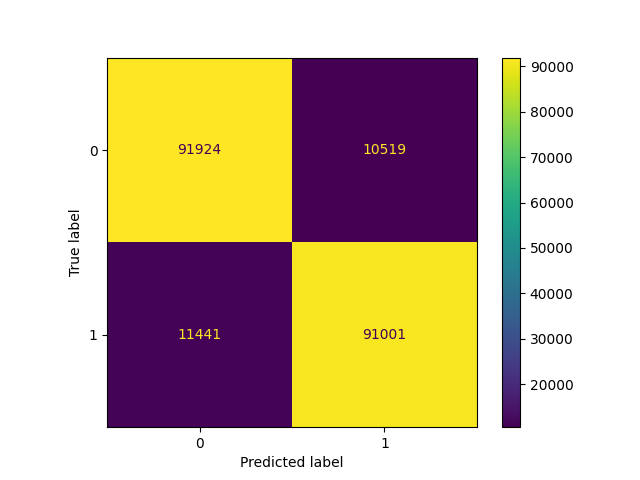

In [218]:
%matplot plt

In [219]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [220]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8928179222490665
Precision is:  0.8963849487785658
Recall is:  0.8883172917358115
F1 Score is:  0.8923328855375021

In [221]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.89      0.90      0.89    102443
           1       0.90      0.89      0.89    102442

    accuracy                           0.89    204885
   macro avg       0.89      0.89      0.89    204885
weighted avg       0.89      0.89      0.89    204885

In [332]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [333]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [334]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

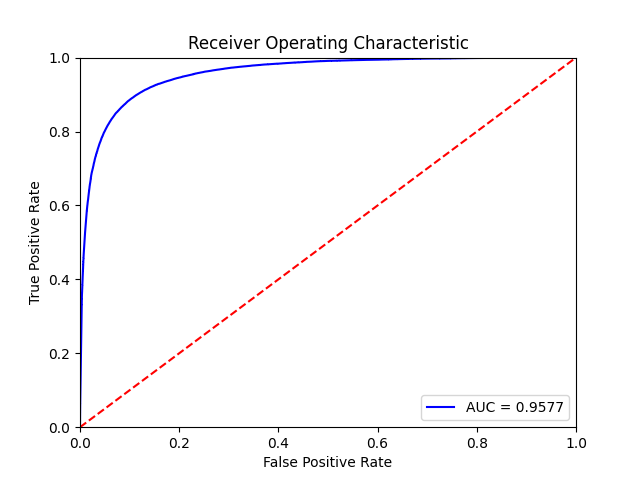

In [335]:
%matplot plt

In [336]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.5011553148098223
Optimal tpr value: 0.8880537279631401
Optimal fpr value: 0.10233007623751744

In [337]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [338]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.892861849330112
Precision is:  0.89667543885587
Recall is:  0.8880537279631401
F1 Score is:  0.8923437584294185

In [339]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

204885

In [341]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
pr_auc = metrics.auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [342]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [343]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

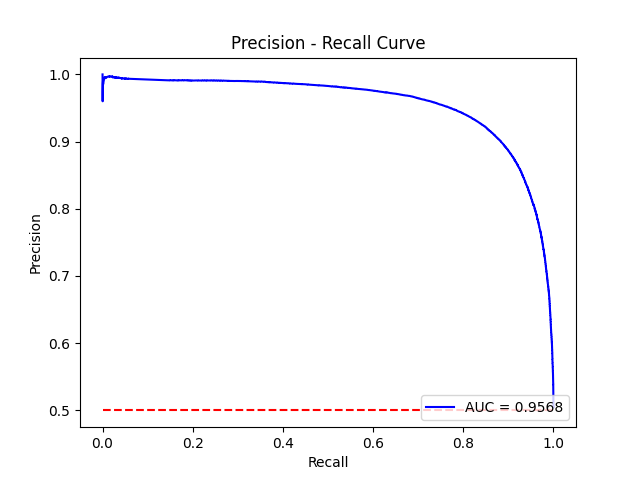

In [344]:
%matplot plt

In [345]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.445000, F-Score=0.893
Recall=0.904902
Precision=0.882101

In [346]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [347]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

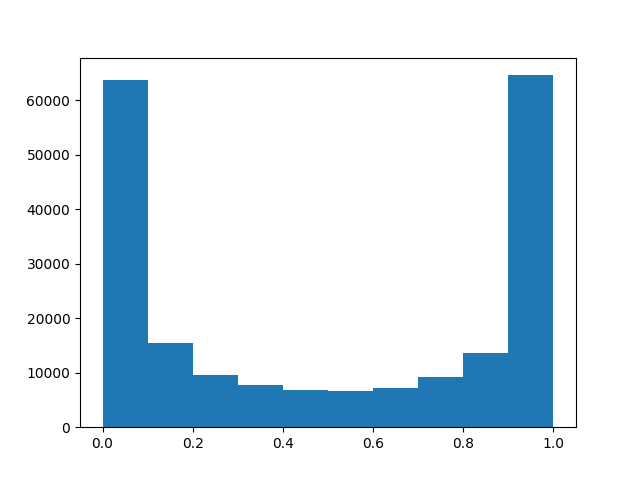

In [348]:
%matplot plt

In [349]:
preds_df = pd.DataFrame(data=preds, columns = ['pred_prob'])
#preds_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [350]:
ytest.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [351]:
hist_plot_data = pd.concat([ytest, preds_df], axis = 1)
#hist_plot_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [352]:
NR_0 = hist_plot_data.loc[hist_plot_data.NR == 0, 'pred_prob']
NR_1 = hist_plot_data.loc[hist_plot_data.NR == 1, 'pred_prob']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [356]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [357]:
kwargs = dict(alpha=0.5, bins=20)

plt.hist(NR_0, **kwargs, color='b', label='NR=0')
plt.hist(NR_1, **kwargs, color='g', label='NR=1')
plt.gca().set(title='Histogram of NR Label Probs', ylabel='Frequency', xlabel = 'Predicted Probability')
plt.legend();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

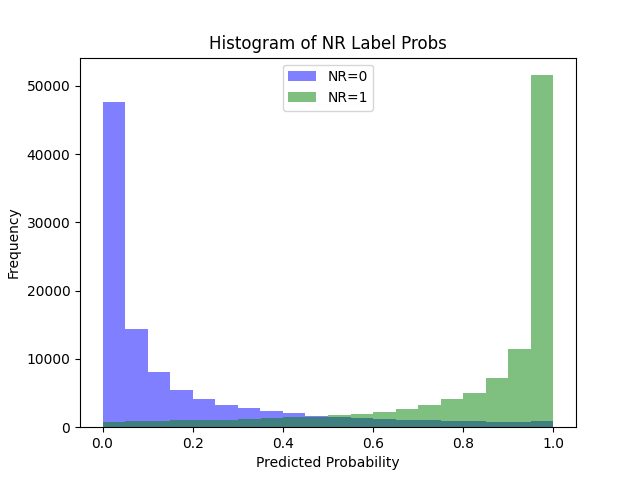

In [358]:
%matplot plt

In [316]:
#Amount of data that is actually 0 but predicted as 1 with probability > 80%
hist_plot_data.loc[(hist_plot_data.NR == 0) & (hist_plot_data.pred_prob > 0.8)].count()
#3233 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3233
pred_prob    3233
dtype: int64

In [317]:
#Amount of data that is actually 1 but predicted as 0 with probability < 20%
hist_plot_data.loc[(hist_plot_data.NR == 1) & (hist_plot_data.pred_prob < 0.2)].count()
#3683 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3683
pred_prob    3683
dtype: int64

In [318]:
#Amount of data (0 or 1) that is between probabilities 20% - 80%
hist_plot_data.loc[(hist_plot_data.pred_prob <0.8) & (hist_plot_data.pred_prob > 0.2)].count()
#47346 / 204885 = ~23%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           47346
pred_prob    47346
dtype: int64

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [287]:
xtest.reset_index(drop=True, inplace=True)
hist_plot_data.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
results = pd.concat([xtest, hist_plot_data], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [304]:
results['ALL_TEXT'] = results['ALL_TEXT'].astype(str)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [305]:
results_sparkdf = spark.createDataFrame(results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [306]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [307]:
 results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST_2").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…